In [1]:
from jdaviz import SpecViz

specviz = SpecViz()
specviz.app

/home/erik/miniconda3/envs/jdaviz-dev2/lib/python3.8/site-packages/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')


Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

In [2]:
import specutils

spec_url = 'https://dr14.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid=1323&mjd=52797&fiberid=12'
spec = specutils.Spectrum1D.read(spec_url, cache=True)

specviz.load_data(spec)

In [3]:
# zoom in on Halpha region
v = specviz.app.get_viewer('spectrum-viewer')
v.state.x_min = 6500
v.state.x_max = 6750

In [4]:
v.state.y_min = 0
v.state.y_max=2000

Now use the selection tool to selecct a spectral line and a bit of continuum around it

In [5]:
# THIS SHOULD BE UPDATED WHEN 159/161 are in!
ss = specviz.app.data_collection.subset_groups[-1].subsets[0].subset_state
line_region = specutils.SpectralRegion(ss.lo*spec.spectral_axis.unit, ss.hi*spec.spectral_axis.unit)
line_region

Spectral Region, 1 sub-regions:
  (6563.190901360545 Angstrom, 6576.796343537415 Angstrom) 

In [6]:
from astropy.modeling import models
from specutils.fitting import fit_lines
from  specutils import manipulation

# create a model 
line_model = models.Gaussian1D(mean=(line_region.lower + line_region.upper)/2, 
                               stddev=3, 
                               amplitude=1000) + models.Const1D(200)

#fit that model to the selected region

# after a bug fix, this should be:
# fit_lines(spec, line_model, window=line_region)

extracted = manipulation.extract_region(spec, line_region)
extracted.mask[:] = False
fitted_line = fit_lines(extracted, line_model)
fitted_line

<QuantityModel CompoundModel(amplitude_0=755.26014902, mean_0=6570.13682733, stddev_0=1.71880298, amplitude_1=193.45212782), input_units=Angstrom, return_units=1e-17 erg / (Angstrom cm2 s)>

(0.0, 1000.0)

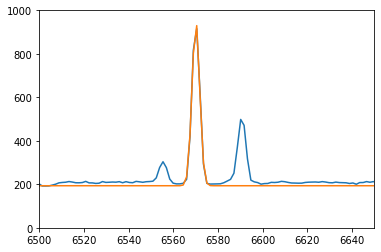

In [7]:
from matplotlib import pyplot as plt
plt.plot(spec.spectral_axis, spec.flux)
plt.plot(spec.spectral_axis, fitted_line(spec.spectral_axis))

plt.xlim(6500, 6650)
plt.ylim(0, 1000)

In [36]:
# integral of just the gaussian part of the line *might* be what you want as 

from scipy.integrate import quad
quad(fitted_line.unitless_model.left, 6500, 6700)[0]*fitted_line.return_units

<Quantity 3253.96293914 1e-17 erg / (Angstrom cm2 s)>